This is a publicly available Spam Classification Dataset. I am demonstrating the use of K nearest neighbor algorithm and how normalization is important in distance based machine learning models.

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from keras.objectives import binary_crossentropy
from livelossplot import PlotLossesKeras
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn import ensemble
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from mlxtend.classifier import StackingClassifier
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')


## Defining Functions

In [4]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# Nested Cross Validation to compare accuracies across models
def nested_cross_validation(model_name, parameters, X_train, y_train, scaler = None):
    NUM_TRIALS = 10
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)

    for i in range(NUM_TRIALS):
        pipeline = Pipeline([('transformer', scaler), ('estimator', model_name)])

        inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

        #clf = GridSearchCV(estimator = model_name, param_grid = parameters, cv=inner_cv)
        clf = GridSearchCV(pipeline, param_grid = parameters, cv=inner_cv)
        clf.fit(X_train, y_train)
        
        pipeline2 = Pipeline([('transformer', scaler), ('estimator', clf)])

        # Nested CV with parameter optimization
        nested_score = cross_val_score(pipeline2, X=X_train, y=y_train, cv=outer_cv)
        nested_scores[i] = nested_score.mean()

    print("The final accuracy from nested cross validation is {0:.2%} / {1:.2%}".format(nested_scores.mean(), \
                                                                                        nested_scores.std()))
    #print("The final accuracy without nested cross validation is {0:.2%}".format(non_nested_scores.mean()))


    accuracy_all_models.append(nested_scores.mean())
    std_all_models.append(nested_scores.std())

In [6]:
def feature_selection_func(estimator, params, X_train, y_train, scaler = None):
    sfs1 = sfs(estimator, k_features='best', forward=True, floating=False, cv=10, scoring = 'accuracy')

    sfs2 = sfs1.fit(X_train, y_train)
    fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()
    print('Selected features:', sfs2.k_feature_idx_)
    X_train_sfs = sfs2.transform(X_train)
    X_test_sfs = sfs2.transform(X_test)
    nested_cross_validation(estimator, params, X_train_sfs, y_train, scaler)

In [7]:
#Creating arrays to store the values of all models to compare different models
accuracy_all_models = []
cross_val_score_all_models = []
precision_all = []
recall_all = []
f_measure_all = []
std_all_models = []

## Data Loading

In [8]:
spam = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header = None)
X = spam.loc[:,0:56]
y = spam.loc[:,57]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y, random_state = 123)

## K Nearest Neighbors Without Normalization 

In [9]:
clf = KNeighborsClassifier()
param = {'estimator__n_neighbors':list(range(1,8)), 'estimator__weights': ["uniform", "distance"]}
nested_cross_validation(clf, param, X_train, y_train)

The final accuracy from nested cross validation is 80.82% / 0.33%


## K Nearest Neighbors With Normalization

In [10]:
clf = KNeighborsClassifier()
param = {'estimator__n_neighbors':list(range(1,8)), 'estimator__weights': ["uniform", "distance"]}
scaler = StandardScaler()
nested_cross_validation(clf, param, X_train, y_train, scaler)

The final accuracy from nested cross validation is 90.92% / 0.28%


## K Nearest Neighbors With Normalization and Sequential Forward Feature Selection

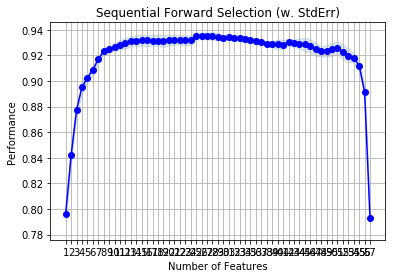

Selected features: (3, 6, 10, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 30, 31, 33, 37, 40, 41, 43, 45, 46, 48, 51, 52)
The final accuracy from nested cross validation is 91.21% / 1.15%


In [11]:
clf = KNeighborsClassifier()
param = {'estimator__n_neighbors':list(range(1,8)), 'estimator__weights': ["uniform", "distance"]}
scaler = StandardScaler()
feature_selection_func(clf, param, X_train, y_train, scaler)

As can be seen from the nested scores, a distance based classifier needs normalized data to perform better and make more accurate predictions. This method can further be modified to account for misclassification cost than just using accuracy as a measure of performance evaluation.

Now looking at the best model out of the three and predicting on test set to evaluate its performance on an unseen dataset.

In [12]:
X_train_subset = X_train.iloc[:,[3, 6, 10, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 30, 31, 33, 37, 40, 41, 43, 45, 46, 48, 51, 52]]
X_test_subset = X_test.iloc[:,[3, 6, 10, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 30, 31, 33, 37, 40, 41, 43, 45, 46, 48, 51, 52]]

In [13]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_subset)
X_test_std = scaler.fit_transform(X_test_subset)


k_range = np.arange(1,30)
param_grid = dict(n_neighbors=k_range)
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, param_grid, cv= 10)
grid.fit(X_train,y_train)
model = grid.best_estimator_
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

print("Prediction Accuracy: {0:.2%}\n".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Prediction Accuracy: 89.90%

             precision    recall  f1-score   support

          0       0.90      0.94      0.92       558
          1       0.90      0.84      0.87       363

avg / total       0.90      0.90      0.90       921



Normalized confusion matrix


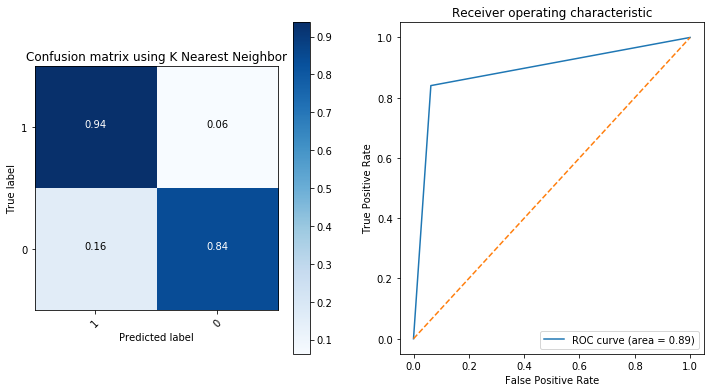

In [14]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(y.unique())

plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using K Nearest Neighbor')

## Predict scores
y_score = model.predict_proba(X_test_std)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#Plot ROC 
# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

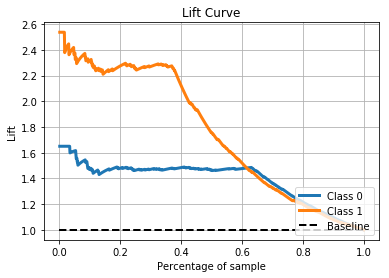

In [15]:
skplt.metrics.plot_lift_curve(y_test,model.predict_proba(X_test_std))
plt.show()